### EDA
@author: Miriela Velazquez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from unicodedata import normalize
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
from unicodedata import normalize
from matplotlib.colors import LinearSegmentedColormap
from langdetect import detect

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

Data Source: https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/data

Kaggle API: `kaggle competitions download -c mercari-price-suggestion-challenge`

#### Utils

In [45]:
# utils for cleaning text in brand_name and category_name

def normalize_text(text):
    '''
    Handles diacritic marks, superscripts and subscripts.
    Returns the text in lowercase.
    '''
    text = text.replace('–', '-').strip()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8").lower()
    return text
    
def remove_stopwords(text:str):
    stop = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

def expand_contractions(text):
    # could have used the library contractions, but there are open issues involving special chars:
    # https://github.com/kootenpv/contractions/issues/25
    # using regex instead: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
    
# clean brand name
def pre_process_brand(text):
    clean_text = normalize_text(text).replace(' ', '_')
    return clean_text

# clean category name
def pre_process_category(text):
    text = expand_contractions(text)
    clean_text = normalize_text(text)
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text).replace(' ', '_')
    return clean_text

def pre_process_description(text):
    text = expand_contractions(text)
    clean_text = normalize_text(text)
    clean_text = re.sub("\[rm\] ","", str(clean_text))
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text)
    clean_text = remove_stopwords(clean_text)
    if(len(clean_text)==0):
        clean_text = 'missing'
    return clean_text

# facilitating categories extraction
def split_category(text, sep):
    try:
        cat_list = text.split(sep)
        if len(cat_list) >= 3:
            return (cat_list[0], cat_list[1], cat_list[2])
        elif len(cat_list) >= 2:
            return (cat_list[0], cat_list[1], 'missing')
        else:
            return (cat_list[0], 'missing', 'missing')
    except:
        return ('missing', 'missing', 'missing')
    
def pre_process_name(text:str):
    clean_text = normalize_text(text)
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text)
    # removing stopwords
    clean_text = remove_stopwords(clean_text)
    if(len(clean_text)==0):
        clean_text = 'missing'
    return clean_text

def generate_wordcloud(text_list, cmap='tab10', bcolor='white'):
    text = " ".join(str(each) for each in text_list)

    # creating the word cloud image:
    wordcloud = WordCloud(max_words=50, colormap=cmap, background_color=bcolor).generate(text)
    plt.figure(figsize=(10,6))

    # image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figure(1,figsize=(10, 10))
    plt.show()
    
def plot_ngrams(corpus, ngram_len, top, ax=None):
    # get n-grams
    #n_grams = ngrams(word_tokenize(text), n)
    tk = word_tokenize(corpus)
    ngrams_series = (pd.Series(ngrams(tk, ngram_len)).value_counts())[:top]
    # plot top n-grams
    title = f'Top {top} {ngram_len}-grams'
    fig = ngrams_series.sort_values().plot.barh(color='blue', title=title, ax=ax)
    fig.bar_label(fig.containers[0])
    return fig 

___

In [5]:
# loading the dataset after being downloaded using kaggle api
data_path = 'data/'
data_file_name = 'product_listings_mercari.tsv'
data_full_path = data_path + data_file_name

product_listings_mercari = pd.read_csv(data_full_path, sep='\t')
product_listings_mercari.shape

(1482535, 8)

In [6]:
product_listings_mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
product_listings_mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [8]:
# checking missing values
display(product_listings_mercari.isna().sum())

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [9]:
# it looks like item_description may have 'No description yet' as value
# which could be treated as missing, similar to NaN
print('Unique item description:', len(product_listings_mercari['item_description'].unique()))
print('No description yet:', len(product_listings_mercari[product_listings_mercari['item_description']=='No description yet']))

Unique item description: 1281427
No description yet: 82489


### Exploring Data

In [10]:
# price
product_listings_mercari['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

<AxesSubplot:>

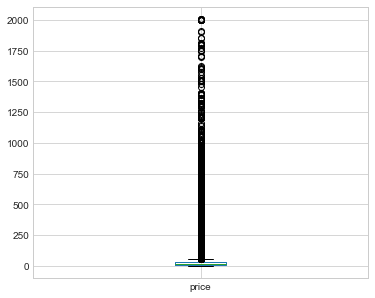

In [11]:
# it looks like the majority of the prices are below ~29 USD
# plotting the data for visual analysis
plt.style.use('seaborn-whitegrid')
product_listings_mercari.boxplot(column='price', figsize=(6,5))

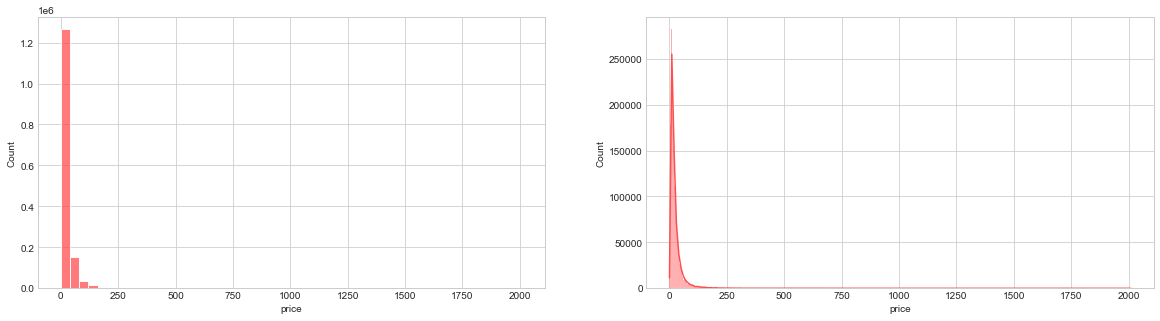

In [12]:
# plotting histogram
fig,ax = plt.subplots(1,2, figsize=(20,5))
# bar
sns.histplot(data=product_listings_mercari, x='price', bins=50, kde=False, ax=ax[0], color='#ff4e4e')
# kde
sns.histplot(data=product_listings_mercari, x='price', bins=500, kde=True, ax=ax[1], color='#ff4e4e')
plt.show()

In [13]:
#sns.FacetGrid(product_listings_mercari, size=6).map(sns.kdeplot,"price").add_legend()
#plt.title('price density distribution')
#plt.show();

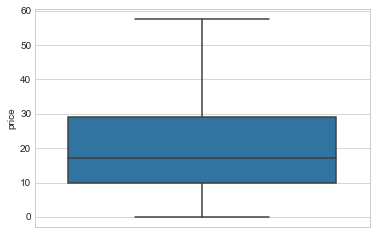

In [14]:
# boxplot without outliers
sns.boxplot(y='price', data=product_listings_mercari, showfliers=False)
plt.show()

<AxesSubplot:xlabel='price', ylabel='Count'>

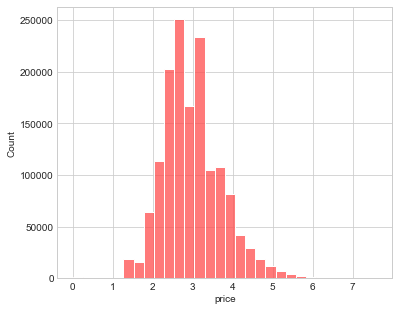

In [15]:
fig,ax = plt.subplots(figsize=(6,5))
sns.histplot(data=product_listings_mercari, x=np.log1p(product_listings_mercari.price), bins=30, kde=False, ax=ax, color='#ff4e4e')

# log of price +1 because there are 0s --> log(0)=undefined.

In [16]:
# the min price is $0 for several listings
product_listings_mercari["price"].eq(0).sum()

874

In [17]:
# assuming that these are cases where someone decides to 'give away' something, or they just set $0 expecting buyers to ask for the actual price,
# regardless of the product condition, brand, etc., then there is no point in suggesting this price

# removing listings where price equals $0
product_listings_mercari = product_listings_mercari[product_listings_mercari['price']>0].reset_index(drop=True)
product_listings_mercari['price'].min() # now the min price is $3

3.0

In [18]:
product_listings_mercari.shape

(1481661, 8)

- 'prices' follows a skewed-right distribution, with the highest concentration (listings) around lower prices
- according to Mercari's [guidelines for listing](https://www.mercari.com/us/help_center/topics/listing/guides/creating-a-listing), prices should be typically set between \\$1 and \\$2000. 
- Listings with prices at \\$0 were removed.
- There is at least one listing with price greater than \\$2000, but the actual limit is \\$5000.
- \\$10 is the most frequent price, confirming that most listings have love prices.

In [19]:
# item condition
product_listings_mercari['item_condition_id'].describe()

count    1.481661e+06
mean     1.907322e+00
std      9.031759e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: item_condition_id, dtype: float64

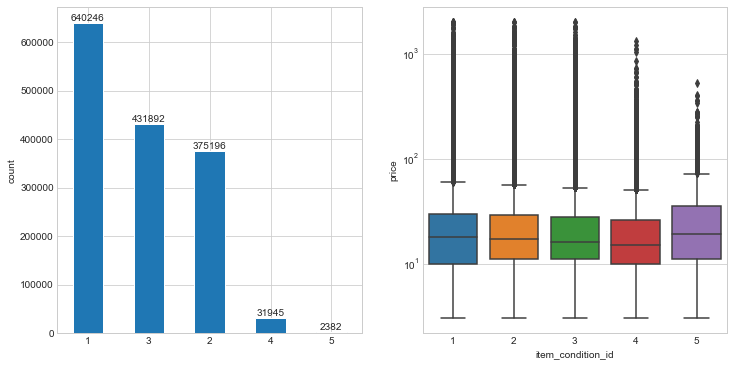

In [20]:
# number of listings by item condition
#product_listings_mercari['item_condition_id'].value_counts()

fig,ax = plt.subplots(1, 2, figsize=(12,6))
# value_counts
product_listings_mercari['item_condition_id'].value_counts().plot(kind='bar', rot=0, ylabel='count', ax=ax[0])
ax[0].bar_label(ax[0].containers[0])

# plotting item condition and price
ax[1].set_yscale("log")
sns.boxplot(x='item_condition_id', y='price', data=product_listings_mercari, ax=ax[1])

plt.show()

- item condition 1 (new) is the most frequent followed by item condition 3 (good).
- products with condition 5 are rarely listed.
- listings with item_condition 5 have the highest median price followed by item_condition 1, so far this is odd since item_condition 1 and 5 represent new (best) and poor (worst) respectively.

In [21]:
# shipping
product_listings_mercari['shipping'].describe()

count    1.481661e+06
mean     4.473257e-01
std      4.972178e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: shipping, dtype: float64

0    818876
1    662785
Name: shipping, dtype: int64

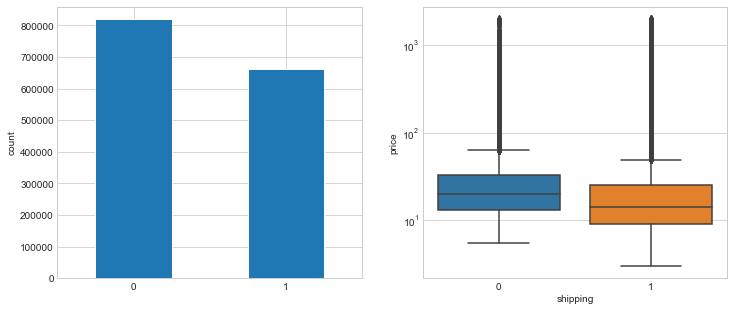

In [23]:
# checking the number of shippings paid by the seller (1) vs the buyer (0)
display(product_listings_mercari['shipping'].value_counts())

fig,ax = plt.subplots(1, 2, figsize=(12,5))
# barplot
product_listings_mercari['shipping'].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count', ax=ax[0])
# boxplot
sns.boxplot(x='shipping', y='price', data=product_listings_mercari, ax=ax[1])
ax[1].set_yscale("log")
plt.show()

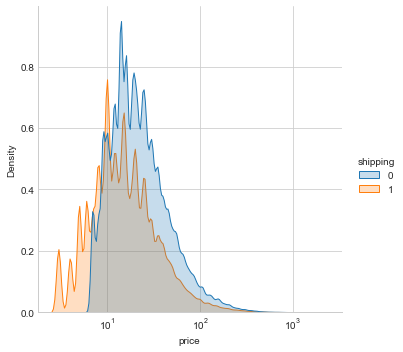

In [24]:
# using log scale in plots for readibility
sns.displot(product_listings_mercari, x='price', hue='shipping', kind='kde', fill=True, log_scale=True)
plt.show()

- listings where shipping is paid by the buyer are more frequent.
- usually when the price is very low, the shiping is paid by the seller
- price tends to be a higher when the buyer pays the shiping

In [25]:
# category
product_listings_mercari['category_name'].describe()
# there are missing values (6314)

count                                            1475347
unique                                              1287
top       Women/Athletic Apparel/Pants, Tights, Leggings
freq                                               60152
Name: category_name, dtype: object

In [26]:
# there are 1287 unique values for this feature, by looking at some of them
# it can be seen that the high number of unique values is probably due to the existence of
# chained levels of categories and sub-categories, leading to multiple possible combinations
product_listings_mercari['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60152
Women/Tops & Blouses/T-Shirts                     46349
Beauty/Makeup/Face                                34320
Beauty/Makeup/Lips                                29901
Electronics/Video Games & Consoles/Games          26547
                                                  ...  
Handmade/Dolls and Miniatures/Primitive               1
Handmade/Pets/Tag                                     1
Handmade/Patterns/Accessories                         1
Home/Kids' Home Store/Nursery Furniture               1
Handmade/Pets/Blanket                                 1
Name: category_name, Length: 1287, dtype: int64

In [27]:
# analyzing the categories and subcategories 
categ_df = pd.DataFrame(product_listings_mercari['category_name'].fillna('missing').str.split('/').to_list())
display(categ_df.head())
categ_df = categ_df.rename(columns={0:'mainCat', 1:'subCat1', 2:'subCat2', 3:'subCat3', 4:'subCat4'})
categ_df.describe()

,0,1,2,3,4
0,Men,Tops,T-shirts,None,None
1,Electronics,Computers & Tablets,Components & Parts,None,None
2,Women,Tops & Blouses,Blouse,None,None
3,Home,Home Décor,Home Décor Accents,None,None
4,Women,Jewelry,Necklaces,None,None


,mainCat,subCat1,subCat2,subCat3,subCat4
count,1481661,1475347,1475347,4385,3055
unique,11,113,870,6,2
top,Women,Athletic Apparel,"Pants, Tights, Leggings",Tablet,eBook Readers
freq,663990,134321,60152,3055,1983


- categories may be chained up to 5 levels from main category to sub-categories.
- excluding missing values, in the records there are 10 main categories, 113 categories at level 1, 870 at level 2, 6 at level 3 and 2 at level 4.
- the first 3 levels are commonly specified in the listing while levels 3 and 4 are rarely set.

In [29]:
# extracting the main three levels of categories from category_name
product_listings_mercari['main_cat'], product_listings_mercari['sub_cat1'], product_listings_mercari['sub_cat2'] = zip(*product_listings_mercari['category_name'].apply(lambda x: split_category(x, '/')))
product_listings_mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


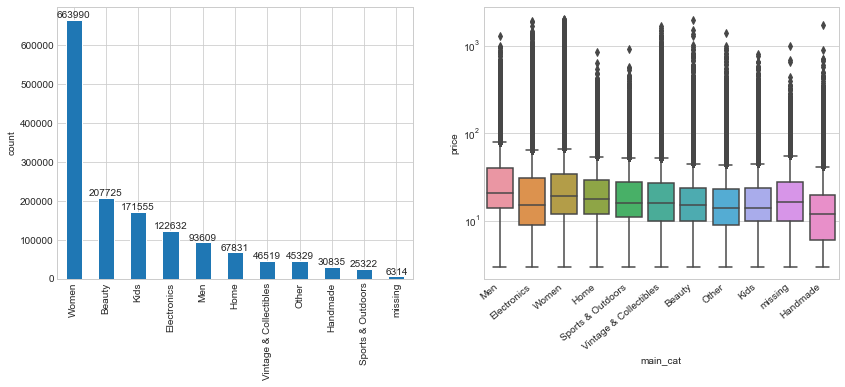

In [30]:
# main category

fig,ax = plt.subplots(1, 2, figsize=(14,5))
product_listings_mercari['main_cat'].value_counts().plot(kind='bar', ylabel='count', ax=ax[0])
ax[0].bar_label(ax[0].containers[0])
sns.boxplot(y='price', x='main_cat', data=product_listings_mercari, ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
plt.show()

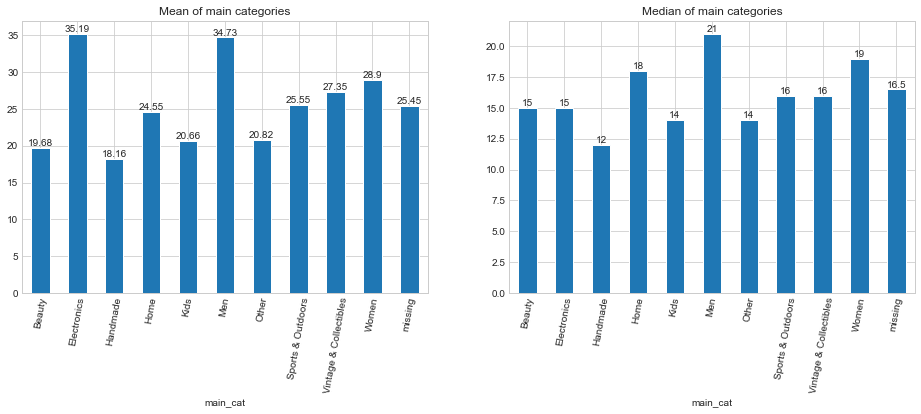

In [31]:
fig,ax = plt.subplots(1, 2, figsize=(16,5))
# mean price for the main categories
product_listings_mercari.groupby('main_cat')['price'].mean().round(2).plot.bar(rot=80, title='Mean of main categories', ax=ax[0]) 
# median price for the main categories
product_listings_mercari.groupby('main_cat')['price'].median().round(2).plot.bar(rot=80, title='Median of main categories', ax=ax[1])

for i in range(len(ax)):
    ax[i].bar_label(ax[i].containers[0])
    
plt.show()

- 'Women' category is the most frequent, tripling the 2nd most frequent.
- 'Men' category shows the highest median price and the highest variation of prices, especially in the lowest 25% of the listings.
- products in the 'Handmade' category have the lowest range of prices.
- there is some variation of prices w.r.t the main category.

Missing subcat_1: 6314


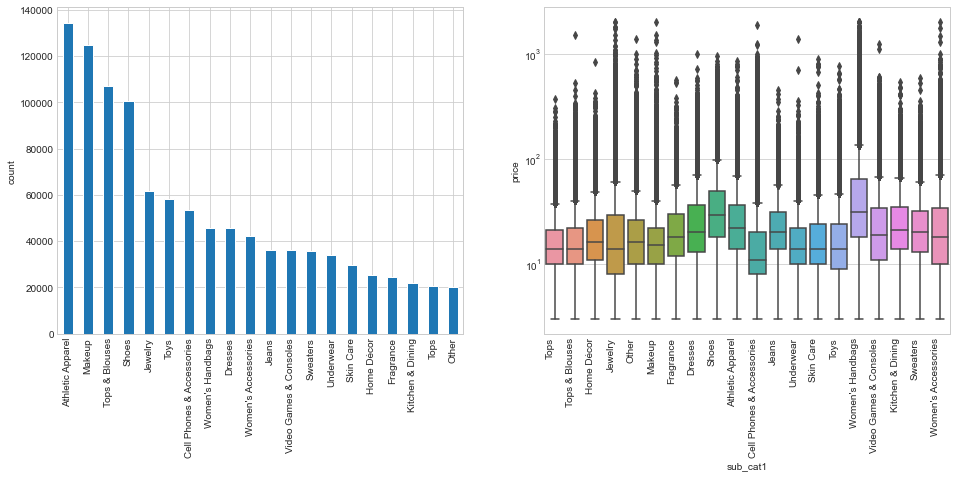

In [32]:
# sub-category 1

# missing_subcat1
print('Missing subcat_1:', len(product_listings_mercari[product_listings_mercari.sub_cat1=='missing']))

fig,ax = plt.subplots(1, 2, figsize=(16,6))
# count
product_listings_mercari['sub_cat1'].value_counts()[:20].plot(kind='bar', ylabel='count', ax=ax[0])
# boxplot
t = product_listings_mercari['sub_cat1'].value_counts()[:20].index.to_list() #product_listings_mercari.sub_cat1.unique()[:20]
sns.boxplot(y='price', x='sub_cat1', data=product_listings_mercari[product_listings_mercari.sub_cat1.isin(t)], ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha="right")
plt.show()

<AxesSubplot:xlabel='sub_cat1', ylabel='price'>

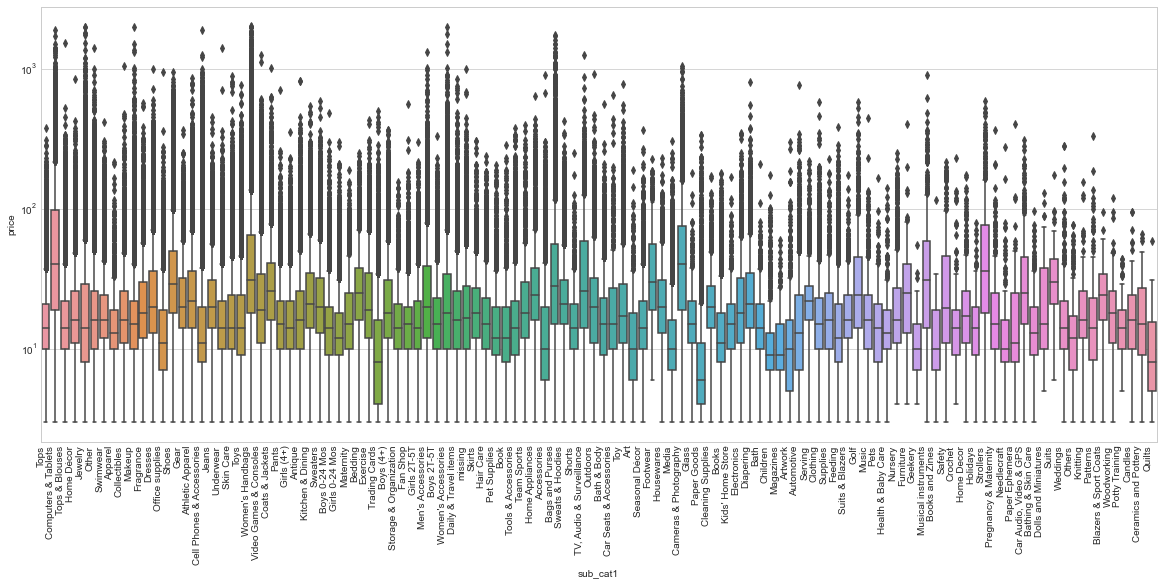

In [33]:
fig,ax = plt.subplots(figsize=(20,8))
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
sns.boxplot(y='price', x='sub_cat1', data=product_listings_mercari)

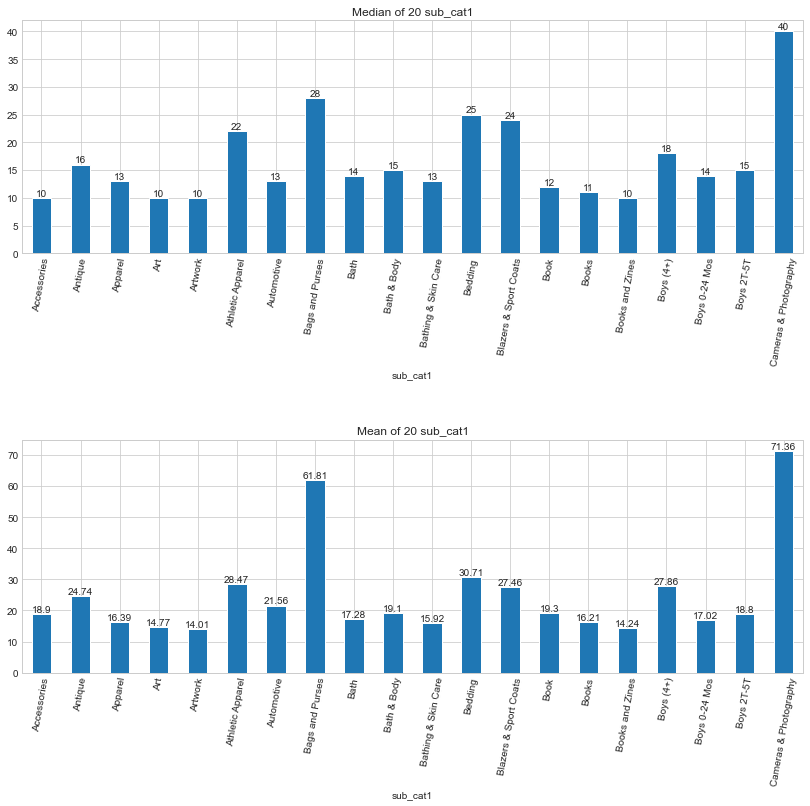

In [34]:
# mean and median price of the first 20 subcategories_1
fig,ax = plt.subplots(2, 1, figsize=(14,12), gridspec_kw={'hspace': 0.8})
# median price
product_listings_mercari.groupby('sub_cat1')['price'].median().round(2)[:20].plot.bar(rot=80, title='Median of 20 sub_cat1', ax=ax[0]) 
# mean price
product_listings_mercari.groupby('sub_cat1')['price'].mean().round(2)[:20].plot.bar(rot=80, title='Mean of 20 sub_cat1', ax=ax[1])

for i in range(len(ax)):
    ax[i].bar_label(ax[i].containers[0])

plt.show()

- there is a strong variation of prices w.r.t sub_cat1.
- Items belonging to the subcategories 'Computers Tablets', 'Cameras Photography', for example, are more expensive if compared to items in 'Paper Goods', 'Office Supplies' subcategories.

Missing subcat_1: 6314


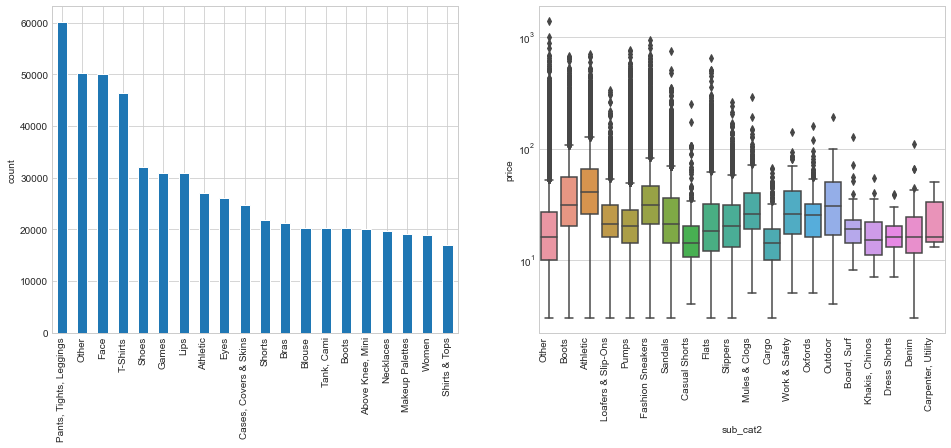

In [37]:
# sub-category 2

# missing_subcat1
print('Missing subcat_1:', len(product_listings_mercari[product_listings_mercari.sub_cat1=='missing']))

fig,ax = plt.subplots(1, 2, figsize=(16,6))
# count
product_listings_mercari['sub_cat2'].value_counts()[:20].plot(kind='bar', ylabel='count', ax=ax[0])
# boxplot
t = product_listings_mercari['sub_cat2'].value_counts()[:20].index.to_list() #product_listings_mercari.sub_cat1.unique()[:20]
sns.boxplot(y='price', x='sub_cat2', data=product_listings_mercari[product_listings_mercari.sub_cat1.isin(t)], ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha="right")
plt.show()

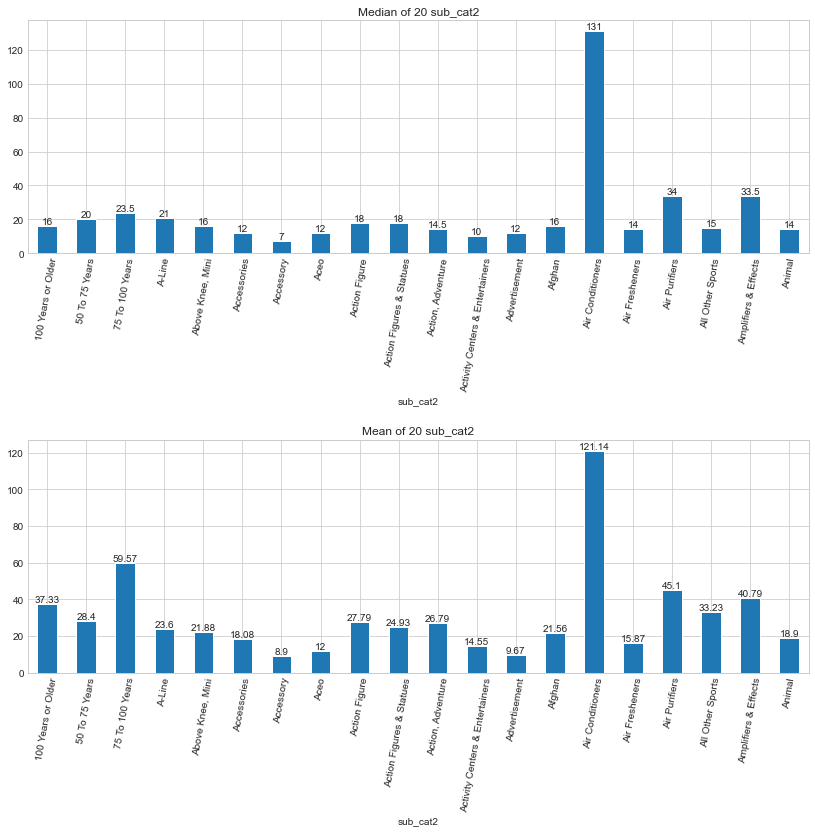

In [38]:
# mean and median price of the first 20 subcategories_1
fig,ax = plt.subplots(2, 1, figsize=(14,12), gridspec_kw={'hspace': 0.8})
# median price
product_listings_mercari.groupby('sub_cat2')['price'].median().round(2)[:20].plot.bar(rot=80, title='Median of 20 sub_cat2', ax=ax[0]) 
# mean price
product_listings_mercari.groupby('sub_cat2')['price'].mean().round(2)[:20].plot.bar(rot=80, title='Mean of 20 sub_cat2', ax=ax[1])

for i in range(len(ax)):
    ax[i].bar_label(ax[i].containers[0])

plt.show()

In [39]:
# normalizing text in category features
#product_listings_mercari['category_name'] = product_listings_mercari['category_name'].map(pre_process_category)
#product_listings_mercari.head()

In [40]:
# name

display(product_listings_mercari['name'].describe())
display(product_listings_mercari['name'][:5])

count     1481661
unique    1224596
top        Bundle
freq         2232
Name: name, dtype: object

0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
Name: name, dtype: object

In [41]:
# cleaning name
product_listings_mercari['name'] = product_listings_mercari['name'].map(pre_process_name)
display(product_listings_mercari['name'][:5])

0    mlb cincinnati reds shirt size xl
1     razer blackwidow chroma keyboard
2                       ava viv blouse
3                leather horse statues
4                 24k gold plated rose
Name: name, dtype: object

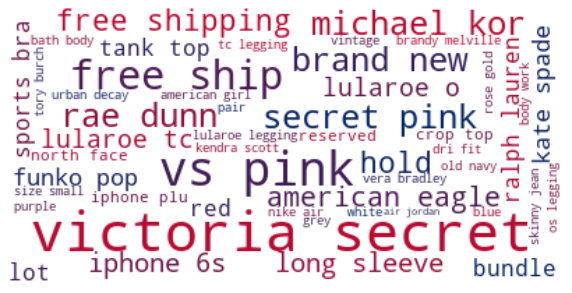

In [42]:
# generating wordcloud
colors = ["#BF0A30", "#002868"] # custom colors instead of plt predefined cmaps
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
generate_wordcloud(product_listings_mercari['name'].values, cmap)

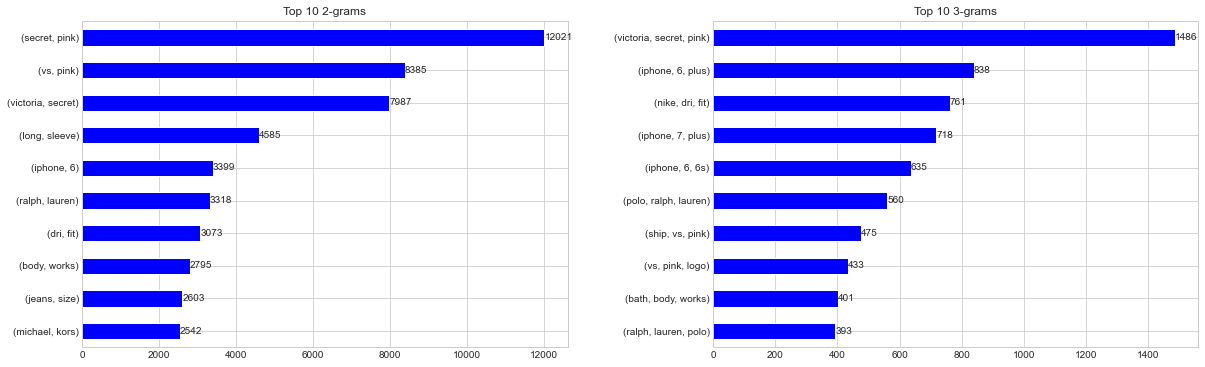

In [46]:
# most frequent 2-grams and 3-grams   
corpus = ''.join((product_listings_mercari['name']))

fig,ax = plt.subplots(1, 2, figsize=(20,6), gridspec_kw={'wspace': 0.3})
plot_ngrams(corpus, 2, 10, ax=ax[0])
plot_ngrams(corpus, 3, 10, ax[1])
plt.show()

- sellers tend to include the item's brand, whether the shipping is free, and also other details about the item.

In [47]:
# item description

# offers a plain-English description of the product, usually, sellers would add as many details as possible to make the listing clear and attractive to buyers. Since description are unique at some extent, it would be expected to have a high cardinality for this feature
display(product_listings_mercari['item_description'].describe())
display(product_listings_mercari['item_description'][:5])
# less than 1% of the listings do not have a description (4 listings as seen previously) 

count                1481657
unique               1280671
top       No description yet
freq                   82427
Name: item_description, dtype: object

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags. Leather horses. Retail for [rm]...
4            Complete with certificate of authenticity
Name: item_description, dtype: object

In [48]:
# cleaning and normalizing text in item description
# filling missing values with 'no description yet'
product_listings_mercari['item_description'] = product_listings_mercari['item_description'].fillna('no description yet')
product_listings_mercari['item_description'] = product_listings_mercari['item_description'].map(pre_process_description)
display(product_listings_mercari['item_description'][:5])

0                                      description yet
1    keyboard great condition works like came box p...
2    adorable top hint lace key hole back pale pink...
3    new tags leather horses retail stand foot high...
4                    complete certificate authenticity
Name: item_description, dtype: object

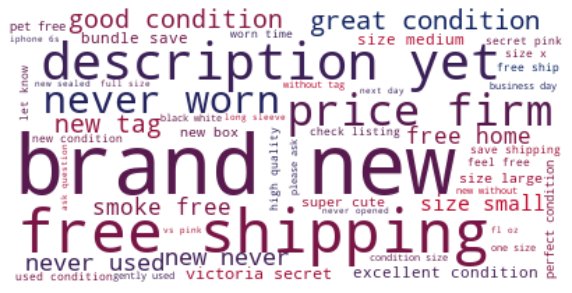

In [49]:
# generating wordcloud
colors = ["#BF0A30", "#002868"] # custom colors instead of plt predefined cmaps
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
generate_wordcloud(product_listings_mercari['item_description'].values, cmap)

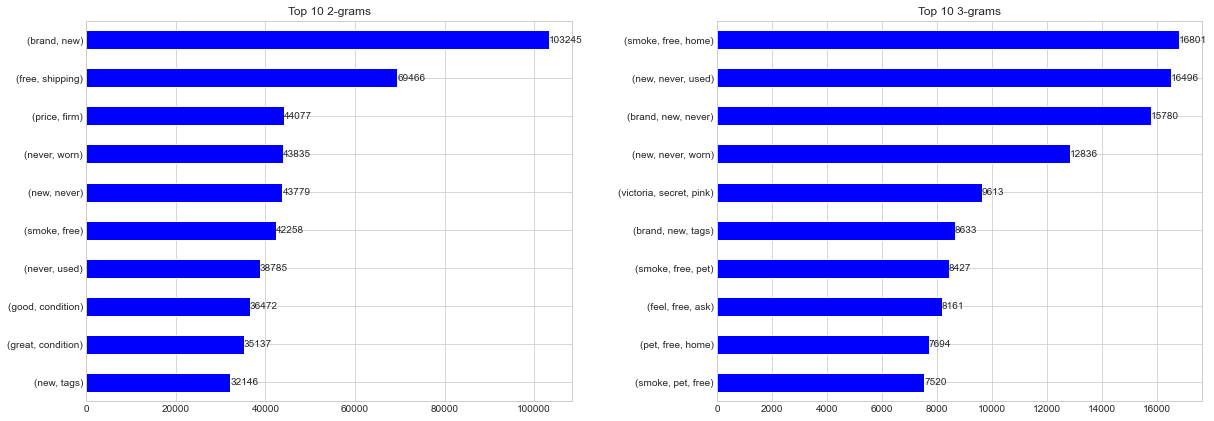

In [50]:
# most frequent 2-grams and 3-grams   
corpus = ''.join((product_listings_mercari['item_description']))

fig,ax = plt.subplots(1, 2, figsize=(20,7), gridspec_kw={'wspace': 0.3})
plot_ngrams(corpus, 2, 10, ax=ax[0])
plot_ngrams(corpus, 3, 10, ax[1])
plt.show()

- the listing description usually restate the item brand, condition, and shipping.
- additionally, the description includes more descriptive features of the item being sold, such as 'never used', 'brand new with tags', etc.

In [51]:
# brand

display(product_listings_mercari['brand_name'].describe())
# 632,336 listings do not have a brand name, which is a significant number

display(sorted(list(product_listings_mercari[product_listings_mercari['brand_name'] != np.nan]['brand_name'].dropna().unique())))

count     849325
unique      4807
top         PINK
freq       54072
Name: brand_name, dtype: object

['!iT Jeans',
 '% Pure',
 '10.Deep',
 '191 Unlimited',
 '1byone',
 '21men',
 '24/7 Comfort Apparel',
 '2K Games',
 '2XU',
 '3.1 Phillip Lim',
 '3M®',
 '47',
 '47 Brand',
 '5.11 Tactical',
 '525 America',
 '5th & Ocean',
 '7 Diamonds',
 '7 For All Mankind®',
 '8732 Apparel',
 '90 Degree By Reflex',
 'A Bathing Ape',
 'A Pea In The Pod',
 'A Plus Child Supply',
 'A Wish Come True',
 'A&A Optical',
 'A&E',
 'A&R Sports',
 'A+D',
 'A-Shirt',
 'A. Byer',
 'A.B.S. by Allen Schwartz',
 'A.D. Sutton & Sons',
 'A.K.A',
 'A.L.C.',
 'A.P.C.',
 'A/X Armani Exchange',
 'AA Aquarium',
 'AB Studio',
 'ABC Studios',
 'ABS by Allen Schwartz',
 'AC/DC',
 'ACCEL',
 'ACDelco',
 'ADAM',
 'AERIN',
 'AG Adriano Goldschmied',
 'AGB',
 'AGUADECOCO',
 'AKA New York',
 'AKIRA',
 'AKOO',
 'ALDO',
 'ALEX AND ANI',
 'ALLOY',
 'ALO Yoga',
 'AMD',
 'AMIA',
 'ANAMA',
 'AND',
 'AND1',
 'ANDREA FENZI',
 'ANGL',
 'API',
 'ARCONA',
 'ART',
 'ASICS',
 'ASOLO',
 'ASOS',
 'ASSETS by Sara Blakely',
 'ASTR',
 'ASUS',
 'AT&T',


In [52]:
# normalizing text in brand_name
# filling missing values with 'missing'
product_listings_mercari['brand_name'] = product_listings_mercari['brand_name'].fillna('missing')
brands = product_listings_mercari['brand_name'].map(normalize_text)

In [54]:
# number of listings with missing brand
len(product_listings_mercari.loc[product_listings_mercari['brand_name']=='missing'])

632336

In [56]:
# dropping category_name
product_listings_mercari.drop(['category_name'], axis=1, inplace=True)

product_listings_mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481661 entries, 0 to 1481660
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1481661 non-null  int64  
 1   name               1481661 non-null  object 
 2   item_condition_id  1481661 non-null  int64  
 3   brand_name         1481661 non-null  object 
 4   price              1481661 non-null  float64
 5   shipping           1481661 non-null  int64  
 6   item_description   1481661 non-null  object 
 7   main_cat           1481661 non-null  object 
 8   sub_cat1           1481661 non-null  object 
 9   sub_cat2           1481661 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 113.0+ MB


In [57]:
# exporting cleaned dataset for next stage
product_listings_mercari.to_csv(data_path+"mercari_eda_cleaned.csv", index=False)